In [1]:
import sys
sys.path.append("../")

In [2]:
import os
from typing import Dict

import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import AutoTokenizer, TFGPT2ForSequenceClassification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt

from src.datasets.sst2 import load_sst2
from src.utils.logger import get_logger
from src.utils.session import reset_session

2024-12-22 12:22:32.131604: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
_ = get_logger()

In [4]:
# in case of OOM

# option1: FP16 precision
# tf.keras.mixed_precision.set_global_policy("mixed_float16")

# option2: decrease batch size
# batch_size = 4 ~ 8

# option3: disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Config

In [5]:
base_model_dir = "../model/"
os.makedirs(base_model_dir, exist_ok=True)

# pretrained model name
pt_model_name = "microsoft/DialogRPT-updown"

# fine tunining model checkpoint name
ckpt_path = os.path.join(base_model_dir, "gpt2_fine_tune_sst2", "ckpt")

## Load Dataset

In [6]:
(X_train_raw, y_train_raw), (X_valid_raw, y_valid_raw), (X_test_raw, y_test_raw) = load_sst2(
    num_sample=5000,
    val_split=True,
)

X_raw = {
    "X_train": X_train_raw,
    "X_valid": X_valid_raw,
    "X_test": X_test_raw,
}

y_raw = {
    "y_train": y_train_raw,
    "y_valid": y_valid_raw,
    "y_test": y_test_raw,
}

[INFO] num train: 3200 (data.py:33)
[INFO] num valid: 800 (data.py:34)
[INFO] num test: 1000 (data.py:35)


## Preproess
<!-- - we will use last hidden states to  -->

### Tokenize input sentences

In [7]:
tokenizer = AutoTokenizer.from_pretrained(pt_model_name)

/usr/local/lib/python3.8/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [8]:
"""
Args:
 - return_tensors: returns numpy array
 - max_length: limit the maximum length of sentence as 30
 - padding: fill with zeros if len(sentence) < max_length
 - truncation: truncate if len(sentence) > max_length

Outputs:
 - input_ids: tokenized input ids
 - attention_mask: 0 if input_ids[i] = [PAD], 1 otherwise
"""

X_tokenized = {
    k: tokenizer(v.tolist(), return_tensors="np", max_length=30, padding="max_length", truncation=True)
    for k, v in X_raw.items()
}

In [9]:
for i in [0, 10, 13, 20]:
    tmp_raw = X_raw["X_train"][i]
    tmp_tokenized = X_tokenized["X_train"]
    tmp_ids = tmp_tokenized["input_ids"][i]
    tmp_att_msk = tmp_tokenized["attention_mask"][i]

    print("==>")
    print(f"[Raw]\n\t{tmp_raw}")
    print(f"[Token ids]\n\t{tmp_ids}")
    print(f"[Ids to token (convert)]\n\t{' '.join(tokenizer.convert_ids_to_tokens(tmp_ids))}")
    print(f"[Ids to token (decode)]\n\t{tokenizer.decode(tmp_ids)}")
    print(f"[Attention Mask]\n\t{tmp_att_msk}")
    print()

==>
[Raw]
	a meditation on faith and madness , frailty is blood curdling stuff
[Token ids]
	[   64 16901   319  4562   290 23208   837  5306  6267   318  2910  1090
    67  1359  3404 50256 50256 50256 50256 50256 50256 50256 50256 50256
 50256 50256 50256 50256 50256 50256]
[Ids to token (convert)]
	a Ġmeditation Ġon Ġfaith Ġand Ġmadness Ġ, Ġfra ilty Ġis Ġblood Ġcur d ling Ġstuff <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|>
[Ids to token (decode)]
	a meditation on faith and madness, frailty is blood curdling stuff<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
[Attention Mask]
	[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

==>
[Raw]
	has all the hallmarks of a 

### One-hot encode labels
Since `TFGPT2ForSequenceClassification` returns logits with shape=(batch_size, 1), we don't need to one-hot encode y-labels here

In [10]:
# y_onehot = {
#     k: tf.keras.utils.to_categorical(v)
#     for k, v in y_raw.items()
# }

## Train model

In [11]:
reset_session()

In [12]:
model = TFGPT2ForSequenceClassification.from_pretrained(pt_model_name, from_pt=True)

2024-12-22 12:22:37.481123: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-22 12:22:37.482707: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-22 12:22:37.482809: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-22 12:22:37.483072: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [13]:
model.summary()

Model: "tfgpt2_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 score (Dense)               multiple                  1024      
                                                                 
 transformer (TFGPT2MainLaye  multiple                 354823168 
 r)                                                              
                                                                 
Total params: 354,824,192
Trainable params: 354,824,192
Non-trainable params: 0
_________________________________________________________________


In [14]:
optimizer = tf.keras.optimizers.Adam(2e-5)

# note that TFBertForSequenceClassification returns logits (not softmax)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [15]:
model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

In [16]:
X_train = dict(X_tokenized["X_train"])
y_train = y_raw["y_train"]

X_valid = dict(X_tokenized["X_valid"])
y_valid = y_raw["y_valid"]

X_test = dict(X_tokenized["X_test"])
y_test = y_raw["y_test"]

print(f"X_train: {X_train['input_ids'].shape}")
print(f"y_train: {y_train.shape}")

print(f"X_train: {X_valid['input_ids'].shape}")
print(f"y_valid: {y_valid.shape}")

print(f"X_train: {X_test['input_ids'].shape}")
print(f"y_test: {y_test.shape}")

X_train: (3200, 30)
y_train: (3200,)
X_train: (800, 30)
y_valid: (800,)
X_train: (1000, 30)
y_test: (1000,)


In [17]:
batch_size = 4
epochs = 10

In [18]:
ckpt_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckpt_path,
    monitor="val_loss",
    mode="min", 
    save_best_only=True,
    save_weights_only=True
)
es_cb = tf.keras.callbacks.EarlyStopping(patience=5, mode="min", verbose=1)
callbacks = [ckpt_cb, es_cb]

In [19]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_valid, y_valid),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/10


2024-12-22 12:23:01.899407: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x425f6420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-22 12:23:01.899432: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2024-12-22 12:23:01.902776: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-22 12:23:01.997371: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


800/800 [==============================] - 129s 113ms/step - loss: 0.3942 - accuracy: 0.8144 - val_loss: 0.2598 - val_accuracy: 0.8988
Epoch 2/10
800/800 [==============================] - 85s 106ms/step - loss: 0.1421 - accuracy: 0.9506 - val_loss: 0.2449 - val_accuracy: 0.9038
Epoch 3/10
800/800 [==============================] - 74s 92ms/step - loss: 0.0575 - accuracy: 0.9797 - val_loss: 0.3403 - val_accuracy: 0.8813
Epoch 4/10
800/800 [==============================] - 74s 92ms/step - loss: 0.0296 - accuracy: 0.9894 - val_loss: 0.3511 - val_accuracy: 0.9038
Epoch 5/10
800/800 [==============================] - 74s 93ms/step - loss: 0.0206 - accuracy: 0.9947 - val_loss: 0.4074 - val_accuracy: 0.9025
Epoch 6/10
800/800 [==============================] - 74s 93ms/step - loss: 0.0180 - accuracy: 0.9944 - val_loss: 0.4072 - val_accuracy: 0.8913
Epoch 7/10
800/800 [==============================] - 74s 93ms/step - loss: 0.0192 - accuracy: 0.9931 - val_loss: 0.4410 - val_accuracy: 0.8863


## Results

### Train History

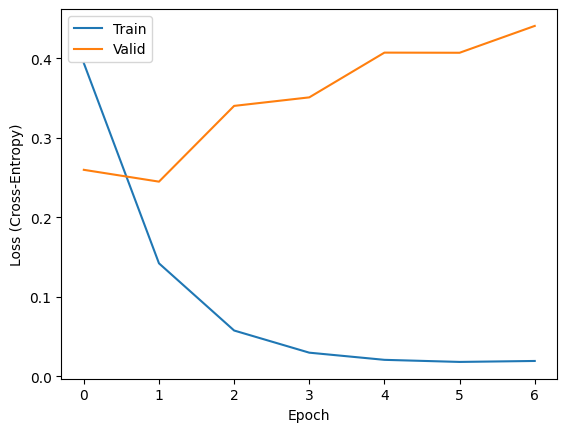

In [20]:
train_loss = history.history["loss"]
valid_loss = history.history["val_loss"]
xticks = range(len(train_loss))

fig, ax = plt.subplots(1, 1)
ax.plot(xticks, train_loss, label="Train")
ax.plot(xticks, valid_loss, label="Valid")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss (Cross-Entropy)")
ax.set_xticks(xticks)
ax.legend()

### Classification Results

In [21]:
def pred_batch(
    model: tf.keras.models.Model,
    inputs: Dict[str, np.ndarray],
    batch_size: int = 4,
    verbose: bool = True,
) -> np.ndarray:
    num_samp = len(inputs["input_ids"])
    num_iter = num_samp // batch_size
    if num_samp % batch_size > 0:
        num_iter += 1
    
    pred_logits = np.empty((0, 1))
    ranges = range(num_iter) if not verbose else tqdm(range(num_iter))
    for i in ranges:
        s, e = i*batch_size, (i+1)*batch_size    
        cur_inputs = {k: v[s:e] for k, v in inputs.items()}
        cur_outputs = model.predict(cur_inputs, verbose=0).logits
        pred_logits = np.vstack([pred_logits, cur_outputs])
    
    return pred_logits

In [22]:
inference_batch_size = 32

In [23]:
pred_logits_train = pred_batch(model, inputs=X_train, batch_size=inference_batch_size, verbose=True)
pred_logits_test = pred_batch(model, inputs=X_test, batch_size=inference_batch_size, verbose=True)

pred_probs_train = tf.nn.sigmoid(pred_logits_train)
pred_probs_test = tf.nn.sigmoid(pred_logits_test)

pred_train = tf.where(pred_probs_train > 0.5, 1.0, 0.0).numpy().reshape(-1)
pred_test = tf.where(pred_probs_test > 0.5, 1.0, 0.0).numpy().reshape(-1)

100% 100/100 [00:21<00:00,  4.55it/s]
100% 32/32 [00:09<00:00,  3.42it/s]


In [24]:
# note that classification_report takes class labels as the input (not one-hot encoded)

print(classification_report(y_train_raw, pred_train))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1544
           1       1.00      1.00      1.00      1656

    accuracy                           1.00      3200
   macro avg       1.00      1.00      1.00      3200
weighted avg       1.00      1.00      1.00      3200



In [25]:
# note that classification_report takes class labels as the input (not one-hot encoded)

print(classification_report(y_test_raw, pred_test))

              precision    recall  f1-score   support

           0       0.90      0.82      0.86       469
           1       0.85      0.92      0.89       531

    accuracy                           0.87      1000
   macro avg       0.88      0.87      0.87      1000
weighted avg       0.88      0.87      0.87      1000

